In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import tensorflow as tf
import numpy as np
import IPython.display as ipd
import time
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
tf.__version__

'2.2.0'

In [3]:
BATCH_SIZE = 32
EPOCHS = 30

In [4]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

X_train = np.expand_dims(np.array(X_train, dtype=np.float32), axis=-1)
X_test = np.expand_dims(np.array(X_test, dtype=np.float32), axis=-1)

X_train /= 255.
X_test /= 255.

np.random.seed(0)
idx = np.random.randint(0, len(X_train), size=30000)
X_train = X_train[idx]
y_train = y_train[idx]

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(30000, 28, 28, 1) (30000,)
(10000, 28, 28, 1) (10000,)


In [5]:
traindataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(len(X_train)).batch(BATCH_SIZE)
testdataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(BATCH_SIZE)

In [6]:
from tensorflow.keras import models, layers, optimizers, losses, metrics

In [7]:
class Classifier(models.Model):
    def __init__(self):
        super(Classifier, self).__init__()
        self.c1 = layers.Conv2D(256, (3,3), activation=tf.nn.relu)
        self.c2 = layers.Conv2D(256, (3,3), activation=tf.nn.relu)
        self.c3 = layers.Conv2D(256, (3,3), activation=tf.nn.relu)
        self.flatten = layers.Flatten()
        self.latent = layers.Dense(4, activation=tf.nn.tanh)
        self.dense = layers.Dense(10, activation=tf.nn.softmax)
        
    def call(self, inputs, training=False):
        x = self.c1(inputs)
        x = self.c2(x)
        x = self.c3(x)
        x = self.flatten(x)
        x = self.latent(x)
        x = self.dense(x)
        return x
    
classifier = Classifier()

In [8]:
loss_obj = losses.SparseCategoricalCrossentropy()
acc_obj = metrics.SparseCategoricalAccuracy()
opt = optimizers.Adam(1e-4)

loss = metrics.Mean()
acc = metrics.Mean()

In [9]:
def train_step(inputs):
    _X, _y = inputs
    
    with tf.GradientTape() as tape:
        pred = classifier(_X)
        _loss = loss_obj(_y, pred)
        
    grads = tape.gradient(_loss, classifier.trainable_variables)
    opt.apply_gradients(list(zip(grads, classifier.trainable_variables)))
    
    loss.update_state(_loss)
    acc.update_state(acc_obj(_y, pred))

In [10]:
def test_step(inputs):
    _X, _y = inputs
    
    pred = classifier(_X)
    _loss = loss_obj(_y, pred)
        
    loss.update_state(_loss)
    acc.update_state(acc_obj(_y, pred))

In [11]:
for e in range(EPOCHS):
    start_time = time.time()
    for x in traindataset:
        train_step(x)
    ipd.clear_output(wait=True)
    print(f"{e+1}/{EPOCHS}, loss={loss.result():.8f}, acc={100*acc.result():.2f}%, {time.time()-start_time:.2f}sec/epoch")
    loss.reset_states()
    acc.reset_states()

30/30, loss=0.20385279, acc=88.00%, 15.97sec/epoch


In [12]:
for x in testdataset:
    test_step(x)
    
print(f"acc={100*acc.result():.2f}%")
loss.reset_states()
acc.reset_states()

acc=88.02%


In [13]:
def get_latent(x):
    for l in classifier.layers[:-1]:
        x = l(x)
    return x

In [14]:
latent = []

for s in range(0, len(X_test), BATCH_SIZE):
    e = min(len(X_test), s+BATCH_SIZE)
    _latent = get_latent(X_test[s:e])
    latent.extend(_latent)
    
latent = np.array(latent)
print(latent.shape)

(10000, 4)


In [15]:
from sklearn.decomposition import PCA

In [34]:
pca = PCA(n_components=2, random_state=0)

In [35]:
latent2d = pca.fit_transform(latent)

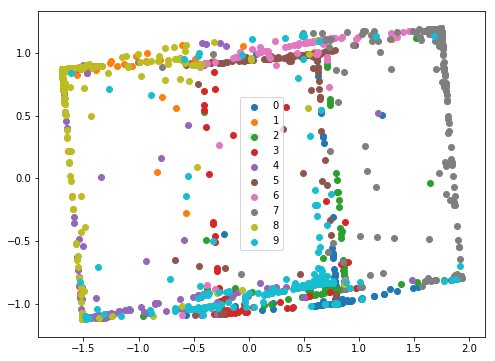

In [36]:
plt.figure(figsize=(8,6))
for i in range(10):
    idx = np.where(y_test==i)
    plt.scatter(latent2d[idx,0], latent2d[idx,1],label=str(i))
plt.legend()
plt.show()